# CE-DDO-OFDM: modulation parameter in a B2B system

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.metrics     import fastBERcalc, signal_power
from optic.core        import parameters
from optic.models      import ssfm, photodiode

from tqdm.notebook     import tqdm
from utils.ofdm        import Tx, Rx, PAPR, demodulateOFDM
from commpy.utilities  import upsample
from tabulate import tabulate

pi = np.pi

In [2]:
import scienceplots

plt.style.use(['science', 'ieee', 'no-latex']) # Problemas com o uso do Latex!

In [3]:
font = {'family':'serif', 'weight':'normal', 'size':14}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

# DDO-OFDM

## 1 - Transmissor

In [70]:
paramTx = parameters()

# Parâmetros do esquema OFDM
paramTx.M    = 16                       # Número de símbolos da constelação QAM
paramTx.Nfft = 1024                      # Tamanho da FFT
paramTx.Ns = int(paramTx.Nfft/2) - 1    # Número de sub-portadoras
paramTx.N  = paramTx.Ns                 # Número de portadoras de informação
paramTx.Nz = paramTx.Ns - paramTx.N     # Número de subportadoras nulas
paramTx.G  = 4                          # Tamanho do prefixo cíclico
paramTx.K  = 4                          # Número de portadoras piloto por bloco OFDM

# Parâmetros da transmissão

Rb = 3e9  # Taxa de bits/s
paramTx.Rs  = Rb*paramTx.Ns*(1 + paramTx.G/paramTx.Nfft) / (np.log2(paramTx.M)*paramTx.N)      # Banda do sinal
paramTx.SpS = 32                        # Amostras por símbolo
Fa = paramTx.Rs*paramTx.SpS             # Frequência de amostragem
paramTx.Scheme = "CE-DD-OFDM"

# Parâmetros da portadora elétrica
paramTx.H  = 0.35/(2*pi)                 # Parâmetro de modulação
paramTx.A  = 1                          # Amplitude
paramTx.fc = 1e9                        # Frequência da portadora [Hz]

# Parâmetros do MZM e potência de entrada
paramTx.Vπ     = 4
paramTx.Vb     = -0.5*paramTx.Vπ
paramTx.Pi_dBm = 3

In [71]:
# Parametrização do sistema

table = [['Grandeza', 'Parâmetro', 'Valor'],
         ['Taxa de transmissão', 'Rb', f'{round(Rb*1e-9, 2)} Gb/s'], 
         ['Tamanho da FFT', 'Nfft', f'{paramTx.Nfft}'], 
         ['Tamanho da constelação', 'M', f'{paramTx.M}'], 
         ['Tamanho do prefixo cíclico', 'G', f'{paramTx.G}'], 
         ['Total de subportadoras', 'Ns', f'{paramTx.Ns}'], 
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Subportadoras anuladas', 'Nz', f'{paramTx.Nz}'],
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Largura de banda', 'Bw', f'{round(paramTx.Rs*1e-9, 2)} GHz'], 
         ['Espaçamento entre subportadoras', 'Delta_f', f'{ round((paramTx.Rs/paramTx.Nfft)*1e-6, 2)} MHz'],
         ['Duração do símbolo OFDM', 'Ts', f'{round((paramTx.Nfft/paramTx.Rs)*1e6,2)} us'],
         ['Duração do prefixo cíclico', 'Tg', f'{round((paramTx.G/paramTx.Rs)*1e9,2)} ns'],
         ['Amplitude da portadora', 'A', f'{round(paramTx.A,2)}'],
         ['Frequência central', 'fc', f'{round((paramTx.fc)*1e-9,2)} GHz'], 
         ['Índice de modulação', '2pi.h', f'{round((2*np.pi*paramTx.H),2)}']]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════════════════════╤═════════════╤══════════╕
│ Grandeza                        │ Parâmetro   │ Valor    │
╞═════════════════════════════════╪═════════════╪══════════╡
│ Taxa de transmissão             │ Rb          │ 3.0 Gb/s │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da FFT                  │ Nfft        │ 512      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da constelação          │ M           │ 16       │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho do prefixo cíclico      │ G           │ 4        │
├─────────────────────────────────┼─────────────┼──────────┤
│ Total de subportadoras          │ Ns          │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras de informação     │ N           │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras anuladas          │ Nz          │ 0        │
├───────────────────────

In [72]:
sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)

#### Sinais no domínio do tempo

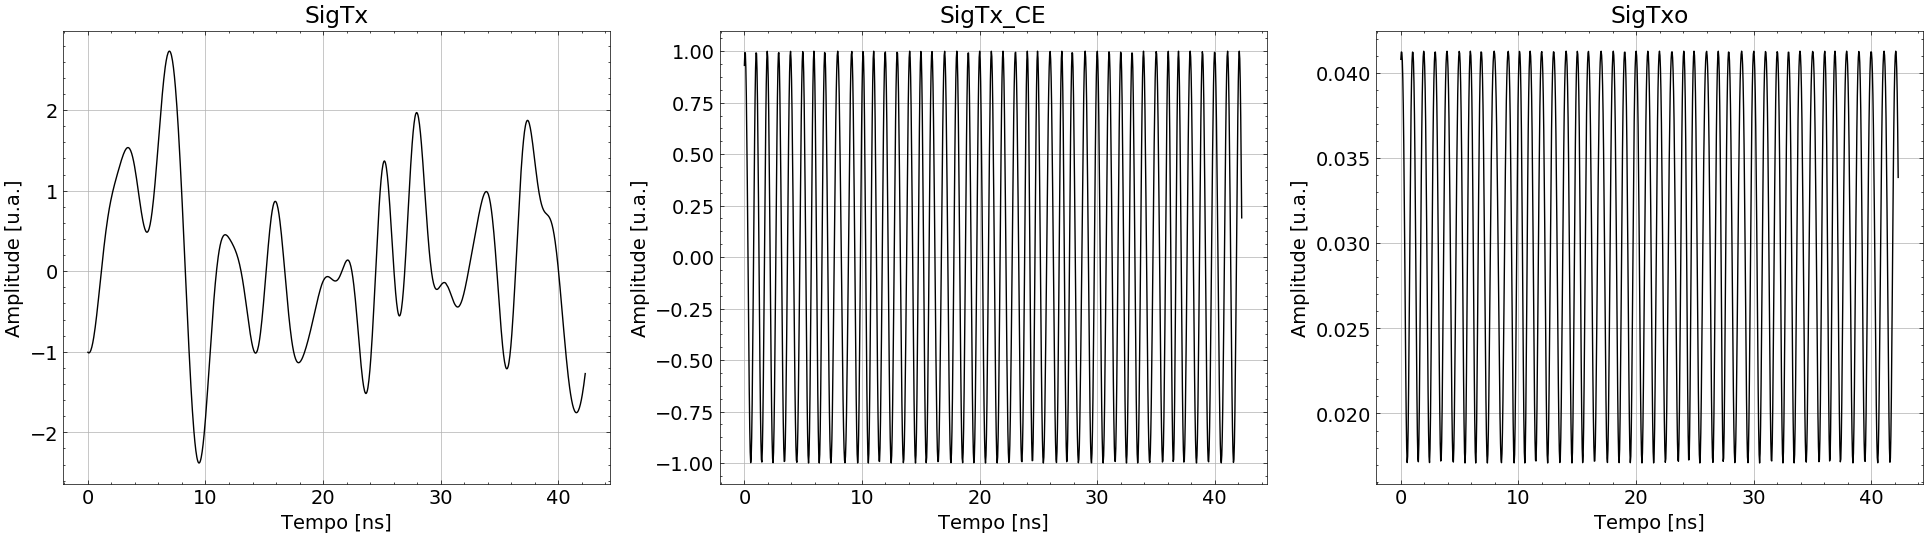

In [73]:
fig, ax = plt.subplots(1, 3, figsize = (24, 6))
idX = np.arange(0, 1024)

ax[0].plot(t[idX]*1e9, sigTx[idX].real)
ax[0].set_xlabel('Tempo [ns]')
ax[0].set_ylabel('Amplitude [u.a.]')
ax[0].set_title('SigTx')
ax[0].grid()

ax[1].plot(t[idX]*1e9, sigTx_CE[idX].real)
ax[1].set_xlabel('Tempo [ns]')
ax[1].set_ylabel('Amplitude [u.a.]')
ax[1].set_title('SigTx_CE')
ax[1].grid()

ax[2].plot(t[idX]*1e9, np.abs(sigTxo[idX]))
ax[2].set_xlabel('Tempo [ns]')
ax[2].set_ylabel('Amplitude [u.a.]')
ax[2].set_title('SigTxo')
ax[2].grid()

#### Espectros

(-205, -86.82514751292128)

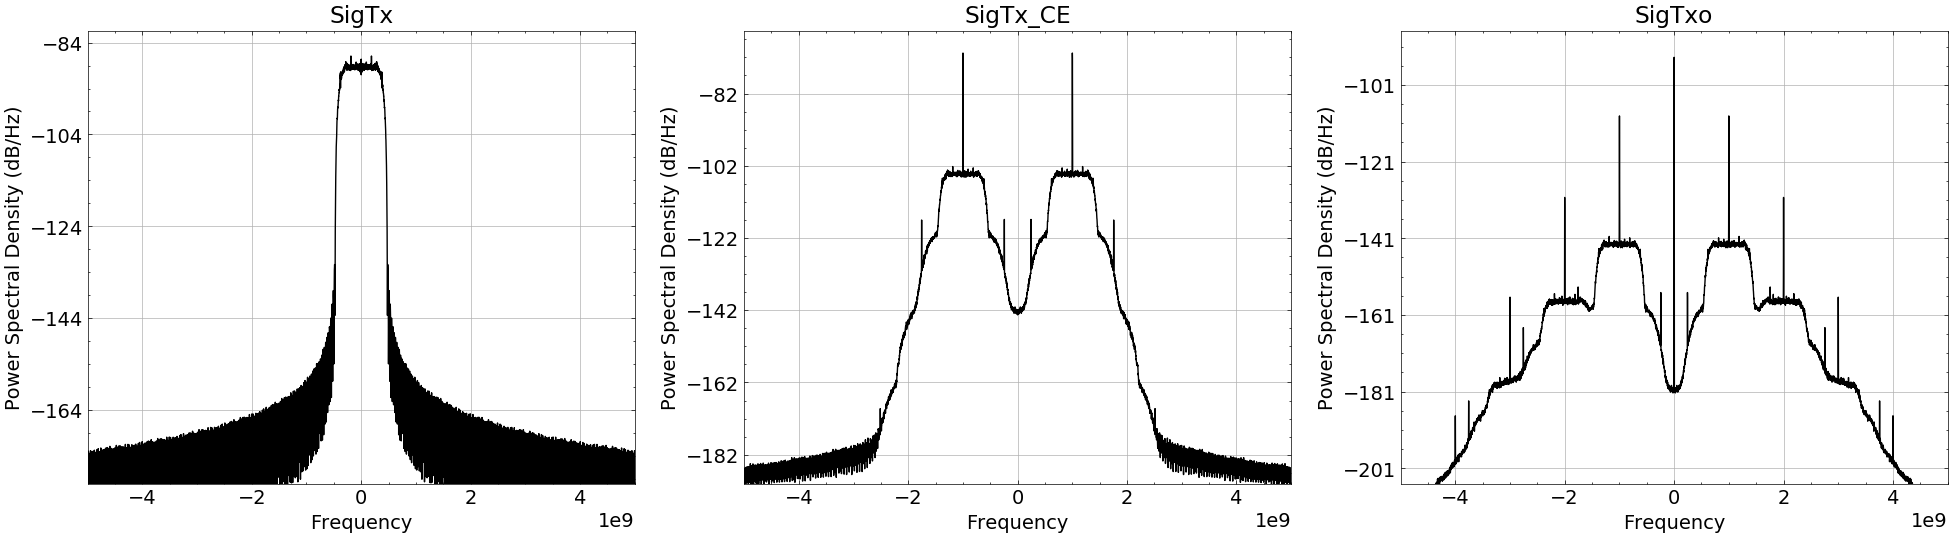

In [74]:
fig, ax = plt.subplots(1, 3, figsize = (24, 6))
idX = np.arange(0, 512)

ax[0].psd(sigTx, Fs=Fa, NFFT = 16*1024, sides='twosided')
ax[0].set_title('SigTx')
ax[0].set_xlim(-5e9, 5e9)
ax[0].set_ylim(-180)

ax[1].psd(sigTx_CE, Fs=Fa, NFFT = 16*1024, sides='twosided')
ax[1].set_title('SigTx_CE')
ax[1].set_xlim(-5e9, 5e9)
ax[1].set_ylim(-190)

ax[2].psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided')
ax[2].set_title('SigTxo')
ax[2].set_xlim(-5e9, 5e9)
ax[2].set_ylim(-205)

In [75]:
# Potência do sinal óptico
print(f" SigTxo - Pi[dBm] = {10*np.log10(1000*signal_power(sigTxo))}")

 SigTxo - Pi[dBm] = -0.010268658079237802


In [76]:
# PAPR
print('PAPR = %.2f dB' %(PAPR(paramTx.Nfft, sigTx_CE)))

PAPR = 3.01 dB


## 2 - Canal óptico

In [102]:
paramCh = parameters()

# Parâmetros da fibra
paramCh.Ltotal  = 800         # Comprimento total do link [km]
paramCh.Lspan   = 80          # Comprimento de um span de fibra [km]
paramCh.hz      = 1.0         # Comprimento do passo para o método SSF [km]
paramCh.alpha   = 0.2         # Atenuação da fibra [dB/km]
paramCh.D       = 16          # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma   = 1.3         # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp     = 'edfa'      # Tipo de amplificador
paramCh.NF      = 4.5         # Figura de ruído do amplificador [dB]
paramCh.Fc      = paramTx.Fc  # Frequência da portadora óptica [Hz]
paramCh.prgsBar = True

In [103]:
sigRxo,_  = ssfm(sigTxo, Fa, paramCh)

  0%|          | 0/10 [00:00<?, ?it/s]

## 3 - Recepção

In [104]:
paramPD = parameters()

# Parâmetros do fotodetector
paramPD.R  = 1           # Responsividade
paramPD.Tc = 25          # Temperatura [°C]
paramPD.Id = 5e-9        # Corrente de escuro [A]
paramPD.RL = 50          # Resistência [Ω]
paramPD.B  = 10e9         # Largura de banda [Hz]
paramPD.Fa = Fa          # Frequência de amostragem
paramPD.N  = 8001        # Tamanho do resposta do filtro
paramPD.ideal = False    # Definição do modelo: ideal ou real

In [105]:
ipd = photodiode(sigRxo, paramPD)

In [106]:
paramRx = parameters()

# Parâmetros do receptor
paramRx.SpS = paramTx.SpS       # Amostras por símbolo
paramRx.Fa  = Fa                # Frequência de amostragem
paramRx.H   = paramTx.H         # Índice de modulação
paramRx.fc  = paramTx.fc        # Frequência da portadora elétrica
paramRx.Scheme = paramTx.Scheme

paramRx.Nfft = paramTx.Nfft
paramRx.Ns = paramTx.Ns
paramRx.Nz = paramTx.Nz
paramRx.G  = paramTx.G
paramRx.K  = paramTx.K

In [107]:
symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

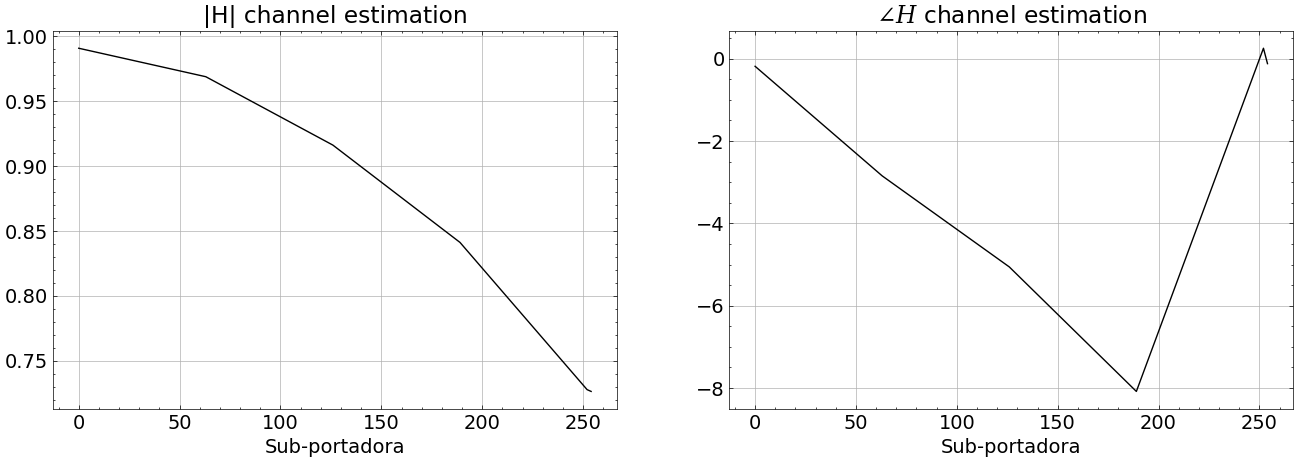

In [108]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(H_abs)
ax[0].set_title("|H| channel estimation")
ax[0].set_xlabel("Sub-portadora")
ax[0].grid()

ax[1].plot(H_pha*180/pi)
ax[1].set_title(r"$\angle H$ channel estimation")
ax[1].set_xlabel("Sub-portadora")
ax[1].grid()

#### Sinal óptico recebido

(-20000000000.0, 20000000000.0)

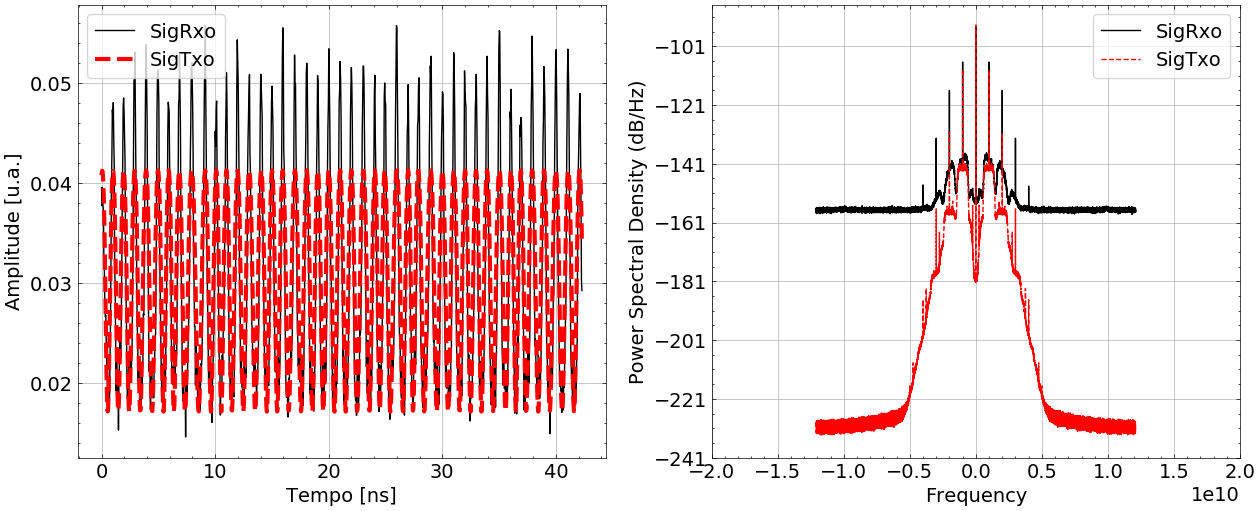

In [109]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
idX = np.arange(0, 1024)

ax[0].plot(t[idX]*1e9, np.abs(sigRxo[idX]), label = "SigRxo")
ax[0].plot(t[idX]*1e9, np.abs(sigTxo[idX]), lw = 3, ls = '--', label = "SigTxo")
ax[0].set_xlabel('Tempo [ns]')
ax[0].set_ylabel('Amplitude [u.a.]')
ax[0].legend(frameon = True)
ax[0].grid()

ax[1].psd(sigRxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = "SigRxo")
ax[1].psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = "SigTxo")
ax[1].legend(frameon = True)
ax[1].set_xlim(-20e9, 20e9)

#### Sinal elétrico recebido

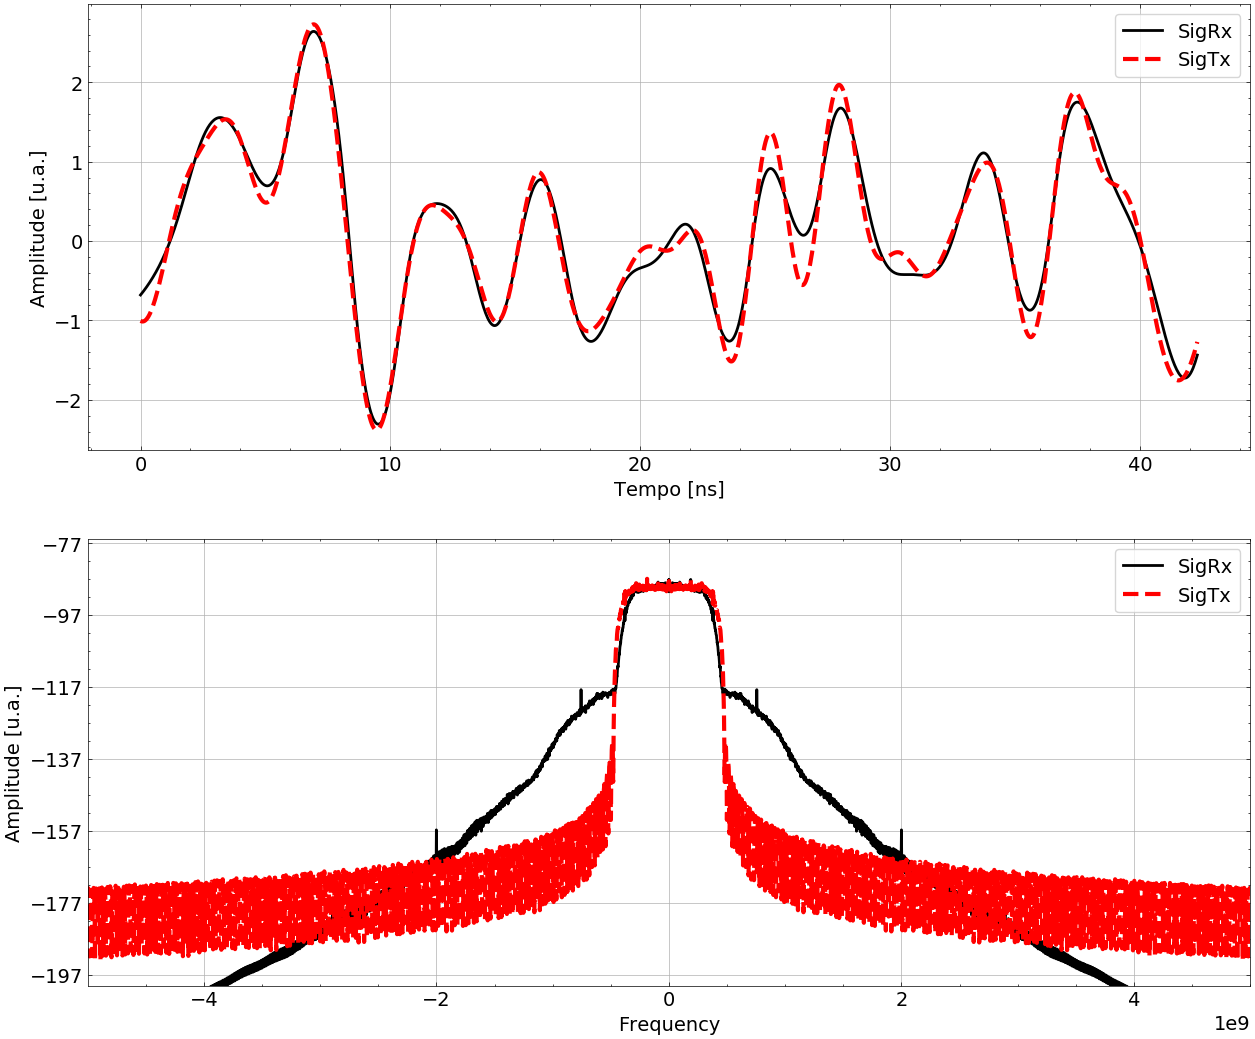

In [110]:
fig, ax = plt.subplots(2, 1, figsize = (15, 13))
idX = np.arange(0, 1024)

ax[0].plot(t[idX]*1e9, sigRx[idX], lw = 2, label = "SigRx")
ax[0].plot(t[idX]*1e9, sigTx[idX].real, lw = 3, label = "SigTx")
ax[0].set_xlabel('Tempo [ns]')
ax[0].set_ylabel('Amplitude [u.a.]')
ax[0].legend(frameon = True)
ax[0].grid()

ax[1].psd(sigRx, Fs=Fa, NFFT = 16*1024, lw = 2, sides='twosided', label = "SigRx")
ax[1].psd(sigTx, Fs=Fa, NFFT = 16*1024, lw = 3, sides='twosided', label = "SigTx")
ax[1].set_ylabel('Amplitude [u.a.]')
ax[1].set_xlim(-5e9, 5e9)
ax[1].set_ylim(-200)
ax[1].legend(frameon = True)

## 4 - Desempenho do sistema

### 4.1 - Com equalização

In [111]:
# Cálculo da BER
np.log10(fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0])

array([-3.68444638])

(-2, 2)

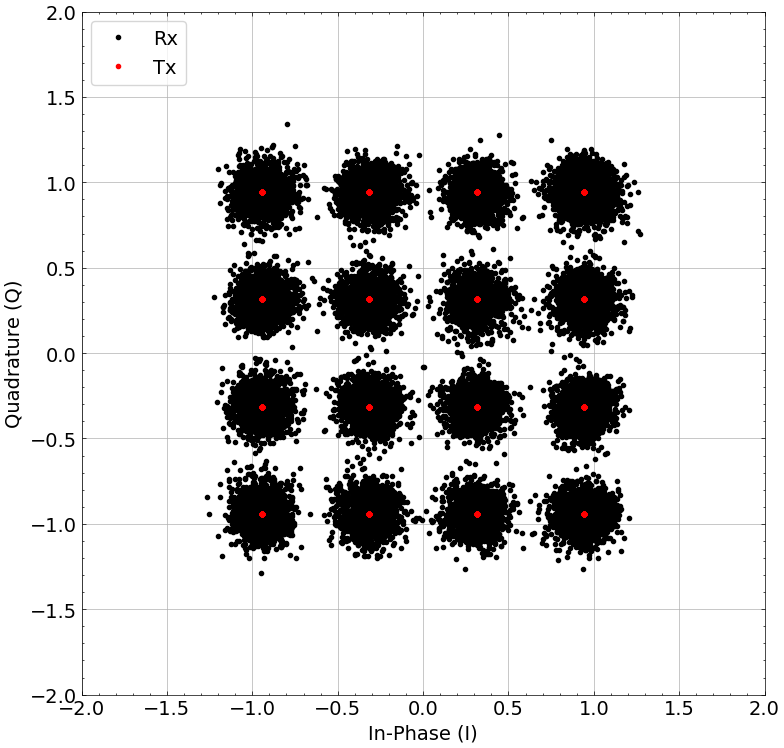

In [112]:
# Plot da constelação transmitida e recebida
plt.figure(figsize=(8, 8))
plt.plot(symbRx.real, symbRx.imag, '.', label = 'Rx')
plt.plot(symbTx.real, symbTx.imag, '.', label = 'Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.legend(loc = 'upper left', frameon = True)
plt.tight_layout()
plt.grid()

plt.xlim(-2,2)
plt.ylim(-2,2)

### 4.2 - Sem equalização

In [113]:
# Cálculo da BER
np.log10(fastBERcalc(symbRx_neq, symbTx, paramTx.M, 'qam')[0])

array([-2.64305369])

(-2, 2)

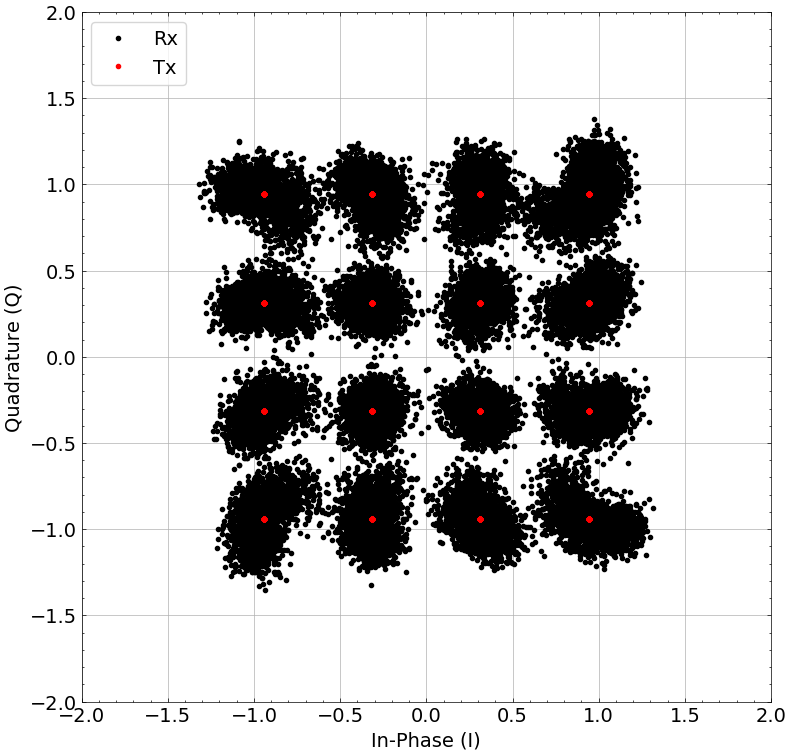

In [114]:
# Plot da constelação transmitida e recebida
plt.figure(figsize=(8, 8))
plt.plot(symbRx_neq.real, symbRx_neq.imag, '.',label = 'Rx')
plt.plot(symbTx.real, symbTx.imag, '.', label = 'Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.legend(loc = 'upper left', frameon = True)
plt.tight_layout()
plt.grid()

plt.xlim(-2,2)
plt.ylim(-2,2)

In [ ]:
# Escolha do Vpi, Vbias e parâmetro OMI (amanhã - 01-12)
# Sensibilidade do parâmetro de modulação 2.pi.h (02-12)